# Sartorius Segmentation By U-Net [Training]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import json

import cv2

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
train_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
print(train_df.shape)
train_df.head(4)

(73585, 9)


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [ ]:
train_df=train_df.head(n=20000)

In [ ]:
#train_df=train_df.sample(n=50000)
#train_df=train_df.reset_index()
#train_df.groupby(['cell_type']).size()

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

def rle2maskResize(rle):
    # CONVERT RLE TO MASK
    if (len(rle)==0):
        return np.zeros((256,256) ,dtype=np.uint8)

    height= 520
    width = 704
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1

    return mask.reshape( (height,width), order='F' )[::2,::2]


(-0.5, 703.5, 519.5, -0.5)

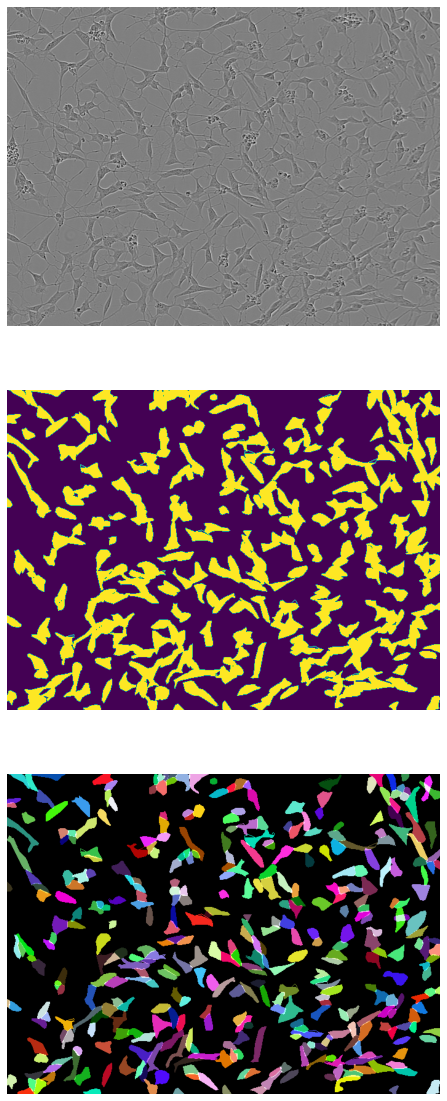

In [ ]:
sample_filename = '0030fd0e6378'
sample_image_df = train_df[train_df['id'] == sample_filename]
sample_path = f"../input/sartorius-cell-instance-segmentation/train/{sample_image_df['id'].iloc[0]}.png"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['annotation'].values

sample_masks1=build_masks(sample_rles,input_shape=(520, 704), colors=False)
sample_masks2=build_masks(sample_rles,input_shape=(520, 704), colors=True)

fig, axs = plt.subplots(3, figsize=(20, 20))
axs[0].imshow(sample_img)
axs[0].axis('off')

axs[1].imshow(sample_masks1)
axs[1].axis('off')

axs[2].imshow(sample_masks2)
axs[2].axis('off')

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/sartorius-cell-instance-segmentation/train',
                 batch_size=32, dim=(256, 256), n_channels=3,
                 n_classes=3, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]

        X = self.__generate_X(list_IDs_batch)

        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y

        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['id'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}.png"
            img = self.__load_grayscale(img_path)


            # Store samples
            X[i,] = img

        return X

    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)

        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['id'].iloc[ID]
            image_df = self.target_df[self.target_df['id'] == im_name]

            rles = image_df['annotation'].values
            masks = build_masks(rles,(520,704), colors=False)
            masks = cv2.resize(masks, (256, 256))
            #masks=masks.transpose(1,0)
            masks=np.expand_dims(masks, axis=-1)
            y[i, ] = masks

        return y

    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # resize image
        dsize = (256, 256)
        img = cv2.resize(img, dsize)

        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img

    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

Dimension of image: (16, 256, 256, 3)
Dimension of mask: (16, 256, 256, 3)


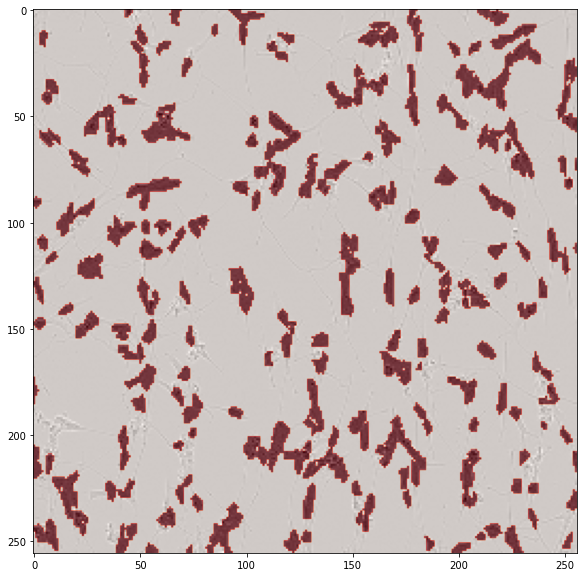

In [ ]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    train_df.index, random_state=2019, test_size=0.2 # mask_count_df
)
train_generator = DataGenerator(
    train_idx,
    df=train_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    n_classes=3
)
val_generator = DataGenerator(
    val_idx,
    df=train_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    n_classes=3
)

plt.figure(figsize=(10,10))
for i in range(1):
    images, mask = val_generator[i]
    print("Dimension of image:", images.shape)
    print("Dimension of mask:", mask.shape)
    plt.imshow(images[0,:,:,0], cmap="gray")
    plt.imshow(mask[0,:,:,0],  alpha=0.6, cmap="Reds")
    plt.show()

# UNET model

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

## Download UNET


In [ ]:
! pip install segmentation-models

     |████████████████████████████████| 50 kB 1.1 MB/s 


In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-w_m17mk9
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-w_m17mk9
  Resolved https://github.com/qubvel/segmentation_models to commit 94f624b7029deb463c859efbd92fa26f512b52b8
  Running command git submodule update --init --recursive -q


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable


model = Unet('efficientnetb0',input_shape=(256, 256, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
#inp = Input(shape=(512, 640, 1))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)
#model = Model(inp, out, name=base_model.name)

model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef,'accuracy']) #bce_dice_loss binary_crossentropy
model.summary()

2021-10-31 16:13:48.346074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 16:13:48.430167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 16:13:48.430956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 16:13:48.432425: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16818176/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
_____________________________

# Training model

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=10
)

2021-10-31 16:13:56.033018: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-10-31 16:14:13.782869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1000/1000 [==============================] - 2385s 2s/step - loss: 0.1812 - dice_coef: 0.8388 - iou_coef: 0.7034 - accuracy: 0.1827 - val_loss: 0.1335 - val_dice_coef: 0.8949 - val_iou_coef: 0.7854 - val_accuracy: 0.1494
Epoch 2/10
1000/1000 [==============================] - 2381s 2s/step - loss: 0.0453 - dice_coef: 0.9584 - iou_coef: 0.8979 - accuracy: 0.1703 - val_loss: 0.0543 - val_dice_coef: 0.9560 - val_iou_coef: 0.8999 - val_accuracy: 0.1450
Epoch 3/10
1000/1000 [==============================] - 2388s 2s/step - loss: 0.0191 - dice_coef: 0.9824 - iou_coef: 0.9494 - accuracy: 0.1568 - val_loss: 0.1597 - val_dice_coef: 0.9168 - val_iou_coef: 0.8367 - val_accuracy: 0.1358
Epoch 4/10
1000/1000 [==============================] - 2384s 2s/step - loss: 0.0098 - dice_coef: 0.9910 - iou_coef: 0.9707 - accuracy: 0.1587 - val_loss: 0.0648 - val_dice_coef: 0.9627 - val_iou_coef: 0.9237 - val_accuracy: 0.1501
Epoch 5/10
1000/1000 [==============================] - 2410s 2s/step - loss: 0.006

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

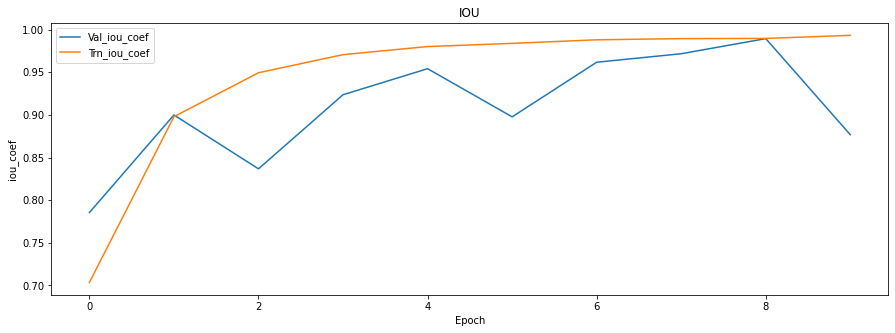

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

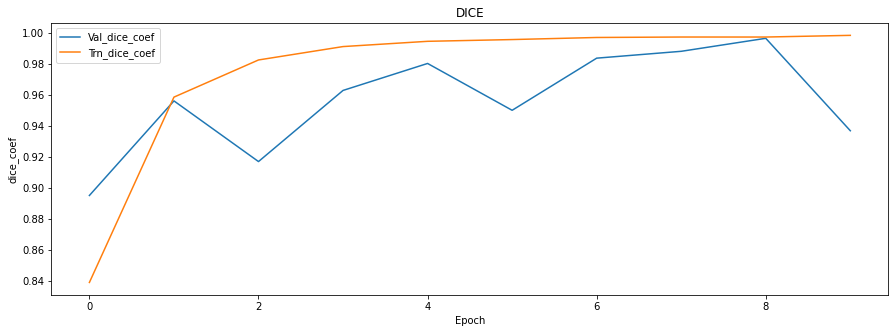

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend();
plt.show()